<a href="https://colab.research.google.com/github/Patisson4/DataAnalysis/blob/main/IR_1_Data_Collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сбор данных

Первый этап любой работы с данными - это их сбор. Тут возможны варианты в зависимости от ситуации и от глобальной задачи. Три общих подхода к сбору данных на Python:
1. скрейпинг, т.е. извлечение данных с веб-страниц
2. парсинг данных по API
3. использование уже написанных библиотек
4. сбор собственного корпуса вручную

# Упражнение 1. Работа с API

Есть проект "Конструктор ОП" http://op.itmo.ru

## Задание 1.0

Доступ к контенту появляется после регистрации. Можно войти через ИСУ, первый вход = регистрация. Для целей лабораторной работы можно либо создать пользователя, либо воспользоваться тестовым.

В процессе работы нужно будет получить данные по API. Собрать по этим данным датасет (например, можно воспользоваться библиотекой pandas). После провести первичный анализ и сделать визуализации.

In [2]:
# пример получение токена для доступа к API

import requests
import json
from datetime import datetime

In [2]:
url = "https://op.itmo.ru/auth/token/login"
auth_data = {"username": "analytic", "password": "datatest"}

In [3]:
token_txt = requests.post(url, auth_data).text

In [4]:
token = json.loads(token_txt)["auth_token"]
headers = {'Content-Type': "application/json", 'Authorization': "Token " + token}

## Задание 1.1 Получить идентификаторы всех учебных планов, имеющихся в op.itmo.ru

In [6]:
allUrl = 'https://op.itmo.ru/api/record/academic_plan/academic_wp_description/all'

Обратите внимание, что у плана есть два разных id. Вам нужно разобраться, какой именно id нужно использовать для следующего пункта задания.


In [ ]:
allResults = []


while True:
  response = requests.get(allUrl, headers=headers).json()
  allResults.extend(response['results'])
  allUrl = response['next']
  if len(allResults) % 100 == 0 or len(allResults) == response['count']:
    print(f"{len(allResults)} out of {response['count']} at {datetime.now()}")
  if allUrl is None:
    break


print(len(allResults))

In [16]:
print(len(allResults))
print(allResults)
print(datetime.now())

1
[{'count': 735, 'next': 'http://op.itmo.ru/api/record/academic_plan/academic_wp_description/all?page=2', 'previous': None, 'results': [{'id': 6796, 'academic_plan_in_field_of_study': [{'id': 6859, 'ap_isu_id': 10572, 'year': 2018, 'title': 'Нанофотоника и квантовая оптика'}], 'wp_in_academic_plan': [{'id': 2623, 'discipline_code': '5546', 'title': 'История', 'description': None, 'status': 'WK'}, {'id': 2625, 'discipline_code': '5664', 'title': 'Физическая культура', 'description': None, 'status': 'WK'}, {'id': 2635, 'discipline_code': '13873', 'title': 'Иностранный язык', 'description': 'Целью освоения дисциплины является достижение следующих результатов обучения: - Знание основ построения основных жанров письменных текстов академической и деловой сферы. - Знание норм композиционного, стилистического и технического оформления письменного текста на иностранном языке. - Умение использовать различные формы и виды письменной коммуникации на иностранном языке в ситуациях профессиональн', 

На всякий случай, скопируем и сохраним данные в файл

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from copy import deepcopy
resultsCopy = deepcopy(allResults)
json.dump(resultsCopy, open('/content/drive/MyDrive/Colab Notebooks/wp_all_nice.txt', 'w'))

Чтобы можно было загрузить

In [6]:
resultsFromFile = json.load(open('/content/drive/MyDrive/Colab Notebooks/wp_all_nice.txt', 'r'))
print(len(resultsFromFile))

735


И скопировать

In [7]:
from copy import deepcopy

allResults = deepcopy(resultsFromFile)

## Задание 1.2 По этим планам получить детальное описание

In [29]:
detailUrl = 'https://op.itmo.ru/api/academicplan/detail'

# пример вызова https://op.itmo.ru/api/academicplan/detail/7292

Планов очень много. Скачивать нужно только планы 2023 и 2024 года набора.

('results' -> 'academic_plan_in_field_of_study' -> 'year')

На основе описаний сделать датасет, состоящий из одной или нескольких таблиц. Добавить время скачивания.

Учтите, что количество планов около 300, скачиваться может довольно долго.

In [37]:
ids = []
for fs in allResults:
  if fs['academic_plan_in_field_of_study'][0]['year'] not in (2023, 2024):
    continue
  isu_id = fs['academic_plan_in_field_of_study'][0]['ap_isu_id']
  fs['isu_id'] = 0 if isu_id is None else isu_id
  del fs['wp_in_academic_plan']
  del fs['academic_plan_in_field_of_study']
  ids.append(fs)

print(len(ids))

274


In [59]:
from pandas import DataFrame

df = DataFrame(ids, dtype=int)
df

,id,isu_id
0,7504,0
1,7505,0
2,7336,18406
3,7334,18399
4,7323,18377
...,...,...
269,7618,41577
270,7632,41357
271,7657,0
272,7650,0


In [70]:
with cf.ThreadPoolExecutor() as ex:
  pass

In [71]:
import concurrent.futures as cf
from datetime import datetime


def load(id: int) -> str:
  print(f"Started with id {id} at {datetime.now()}")
  response = requests.get(detailUrl + f'/{id}', headers=headers)
  print(response.text[:10], end=' ')
  response = response.json()
  fin = datetime.now()
  print(f"Finished with id {id} at {fin}")
  response['timestamp'] = fin
  return response

detailResults = []
with cf.ThreadPoolExecutor(max_workers=4) as ex:
  tasks = [ex.submit(load, row['id']) for (id, row) in df.iterrows()]
  for task in cf.as_completed(tasks):
    detailResults.append(task.result())

print(len(detailResults))

Started with id 7504 at 2024-02-11 20:48:25.871801
Started with id 7505 at 2024-02-11 20:48:25.875249
Started with id 7336 at 2024-02-11 20:48:25.879865
Started with id 7334 at 2024-02-11 20:48:25.882370
{"id":7504 Finished with id 7504 at 2024-02-11 20:49:55.699666
Started with id 7323 at 2024-02-11 20:49:55.702222
{"id":7505 Finished with id 7505 at 2024-02-11 20:49:58.325380
Started with id 7327 at 2024-02-11 20:49:58.325547
{"id":7327 Finished with id 7327 at 2024-02-11 20:50:23.747098
Started with id 7324 at 2024-02-11 20:50:23.747625
{"id":7334 Finished with id 7334 at 2024-02-11 20:50:28.964491
Started with id 7331 at 2024-02-11 20:50:28.965293
{"id":7323 Finished with id 7323 at 2024-02-11 20:50:38.480761
Started with id 7330 at 2024-02-11 20:50:38.480972
{"id":7336 Finished with id 7336 at 2024-02-11 20:50:43.164379
Started with id 7328 at 2024-02-11 20:50:43.165258
{"id":7324 Finished with id 7324 at 2024-02-11 20:50:56.074189
Started with id 7333 at 2024-02-11 20:50:56.08144

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Не забудем сохранить данные в файл

In [ ]:
from copy import deepcopy


detailsCopy = deepcopy(detailResults)
for c in detailsCopy:
  c['timestamp'] = str(c['timestamp'])

with open('/content/drive/MyDrive/Colab Notebooks/wp_details_nice_2.txt', 'w', encoding='utf-8') as f:
    json.dump(detailsCopy, f, ensure_ascii=False, indent=4)

И проверить: что данные корректно выгружаются из файла

In [7]:
import json
t = json.load(open('/content/drive/MyDrive/Colab Notebooks/wp_details_nice.txt', 'r'))
print(len(t))
print(t[0])

detailResults = deepcopy(t)

274
{'id': 7504, 'educational_profile': 'Робототехника и искусственный интеллект / Robotics and artificial intelligence', 'number': None, 'approval_date': '2023-10-06T11:11:04.613383Z', 'discipline_blocks_in_academic_plan': [{'id': 30066, 'name': 'Блок 1. Модули (дисциплины)', 'modules_in_discipline_block': [{'id': 166667, 'name': 'Включенное обучение / Exchange Students', 'type': 'faculty_module', 'change_blocks_of_work_programs_in_modules': [{'id': 985915, 'code': None, 'credit_units': None, 'change_type': 'Required', 'work_program': [{'id': 18480, 'wp_in_fs_id': 1169598, 'approval_date': '2021-04-16T09:46:32.700131Z', 'authors': 'Томашевич С.И., доцент практики , ФСУиР', 'discipline_code': '17043', 'title': 'Программирование роботов / Robot Programming', 'qualification': 'master', 'hoursFirstSemester': None, 'hoursSecondSemester': None, 'zuns_for_wp': [{'id': 1169598, 'zun_in_wp': []}], 'ze_v_sem': '3, 3, 0, 0, 0, 0', 'number_of_semesters': 2, 'wp_status': 'AC'}], 'discipline_block_

In [22]:
from pandas import DataFrame

ddf = DataFrame(detailResults)
ddf['ap_isu_id'] = ddf['ap_isu_id'].fillna(0).astype(int)
ddf['year'] = ddf['academic_plan_in_field_of_study'].apply(lambda x: x[0]['year'])
ddf['qualification'] = ddf['academic_plan_in_field_of_study'].apply(lambda x: x[0]['qualification'])
ddf['structural_unit'] = ddf['academic_plan_in_field_of_study'].apply(lambda x: x[0]['structural_unit']['title'] if x[0]['structural_unit'] is not None else 'NotFound')
ddf['editors'] = ddf['academic_plan_in_field_of_study'].apply(lambda x: x[0]['editors'])
ddf

,id,educational_profile,number,approval_date,discipline_blocks_in_academic_plan,year,education_form,qualification,author,academic_plan_in_field_of_study,...,on_check,excel_generation_errors,laboriousness,can_edit,can_validate,was_send_to_isu,rating,timestamp,structural_unit,editors
0,7504,Робототехника и искусственный интеллект / Robo...,None,2023-10-06T11:11:04.613383Z,"[{'id': 30066, 'name': 'Блок 1. Модули (дисцип...",2023,internal,master,4680.0,"[{'id': 7657, 'year': 2023, 'qualification': '...",...,verified,{'wp_err': []},36,False,False,False,False,2024-02-11 20:49:55.699666,NotFound,[]
1,7505,План Б,None,2023-10-09T16:12:31.803445Z,"[{'id': 30070, 'name': 'Блок 1. Модули (дисцип...",2023,internal,bachelor,4680.0,"[{'id': 7658, 'year': 2023, 'qualification': '...",...,in_work,None,0,False,False,False,False,2024-02-11 20:49:58.325380,NotFound,"[{'id': 6132, 'username': '414329', 'first_nam..."
2,7327,None,None,2022-11-30T20:04:17.149792Z,"[{'id': 29442, 'name': 'Блок 1. Модули (дисцип...",2023,None,master,NaN,"[{'id': 7639, 'year': 2023, 'qualification': '...",...,verified,{'wp_err': []},120,False,False,True,False,2024-02-11 20:50:23.747098,факультет цифровых трансформаций,"[{'id': 143, 'username': '252807', 'first_name..."
3,7334,None,None,2022-11-30T20:04:17.234683Z,"[{'id': 29470, 'name': 'Блок 1. Модули (дисцип...",2023,None,master,NaN,"[{'id': 7398, 'year': 2023, 'qualification': '...",...,verified,{'wp_err': []},120,False,False,True,False,2024-02-11 20:50:28.964491,факультет программной инженерии и компьютерной...,"[{'id': 111, 'username': '279087', 'first_name..."
4,7323,None,None,2022-11-30T20:04:17.102186Z,"[{'id': 29426, 'name': 'Блок 1. Модули (дисцип...",2023,None,master,NaN,"[{'id': 7387, 'year': 2023, 'qualification': '...",...,verified,{'wp_err': []},120,False,False,True,False,2024-02-11 20:50:38.480761,институт прикладных компьютерных наук,"[{'id': 97, 'username': '276726', 'first_name'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,7632,None,None,2023-11-16T07:52:41.998558Z,"[{'id': 30834, 'name': 'Блок 1. Модули (дисцип...",2024,None,bachelor,NaN,"[{'id': 7795, 'year': 2024, 'qualification': '...",...,verified,"{'wp_err': ['В РПД 17526 ""Физическая культура ...",240,False,False,True,False,2024-02-11 22:49:57.693325,факультет экотехнологий,"[{'id': 110, 'username': '241191', 'first_name..."
270,7650,Фотоника и оптические информационные технологи...,None,2023-12-12T14:38:19.251050Z,"[{'id': 30906, 'name': 'Блок 1. Модули (дисцип...",2024,internal,bachelor,775.0,"[{'id': 7813, 'year': 2024, 'qualification': '...",...,verified,"{'wp_err': ['В РПД 30733 ""Военная теория / Mil...",240,False,False,True,False,2024-02-11 22:50:07.901354,NotFound,"[{'id': 632, 'username': '113365', 'first_name..."
271,7657,Устойчивое развитие и экологическое управление,None,2024-01-29T17:25:55.371793Z,"[{'id': 30934, 'name': 'Блок 1. Модули (дисцип...",2024,internal,master,2022.0,"[{'id': 7820, 'year': 2024, 'qualification': '...",...,verified,{'wp_err': []},120,False,False,True,False,2024-02-11 22:50:14.077217,NotFound,"[{'id': 100, 'username': '165829', 'first_name..."
272,7546,None,None,2023-11-16T07:52:40.620521Z,"[{'id': 30490, 'name': 'Блок 1. Модули (дисцип...",2024,None,bachelor,NaN,"[{'id': 7709, 'year': 2024, 'qualification': '...",...,verified,"{'wp_err': ['В РПД 17526 ""Физическая культура ...",240,False,False,True,False,2024-02-11 22:50:20.655641,факультет систем управления и робототехники,"[{'id': 207, 'username': '136977', 'first_name..."


## Задание 1.3 Построить графики и проанализировать

Построить графики: количество планов по годам набора, квалификациям (field_of_study -> 0 -> qualification), структурным подразделениям (structural unit -> title или short_title) и количеству редакторов.

Для планов 2023 и 2024 годов набора построить график с распределением статусов (on_check).

<Axes: title={'center': 'Распределение планов по годам'}>

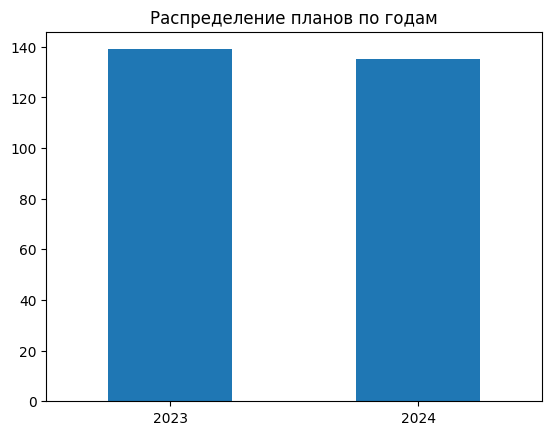

In [192]:
ddf['year'].value_counts().plot(kind='bar', title='Распределение планов по годам', rot=0)

<Axes: title={'center': 'Распределение планов по квалификациям'}>

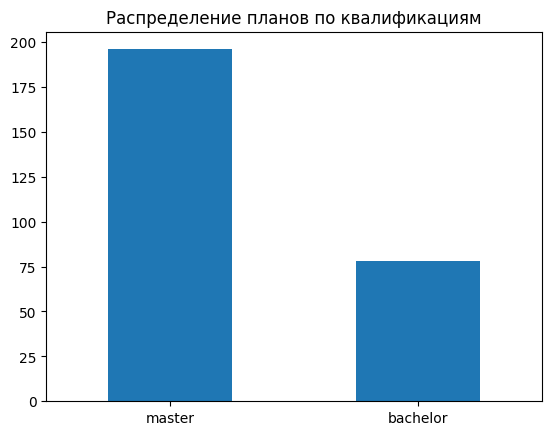

In [193]:
ddf['qualification'].value_counts().plot(kind='bar', title='Распределение планов по квалификациям', rot=0)

<Axes: title={'center': 'Распределение по годам и квалификациям'}>

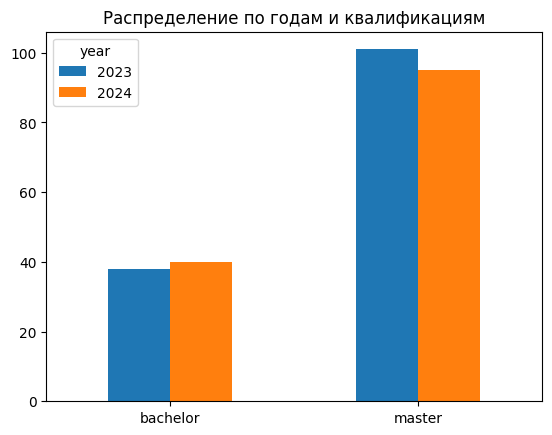

In [194]:
from pandas import crosstab

ct = crosstab(ddf['qualification'], ddf['year'])

ct.plot.bar(rot=0, title='Распределение по годам и квалификациям', xlabel='')

<Axes: title={'center': 'Распределение по годам и структурным подразделениям'}>

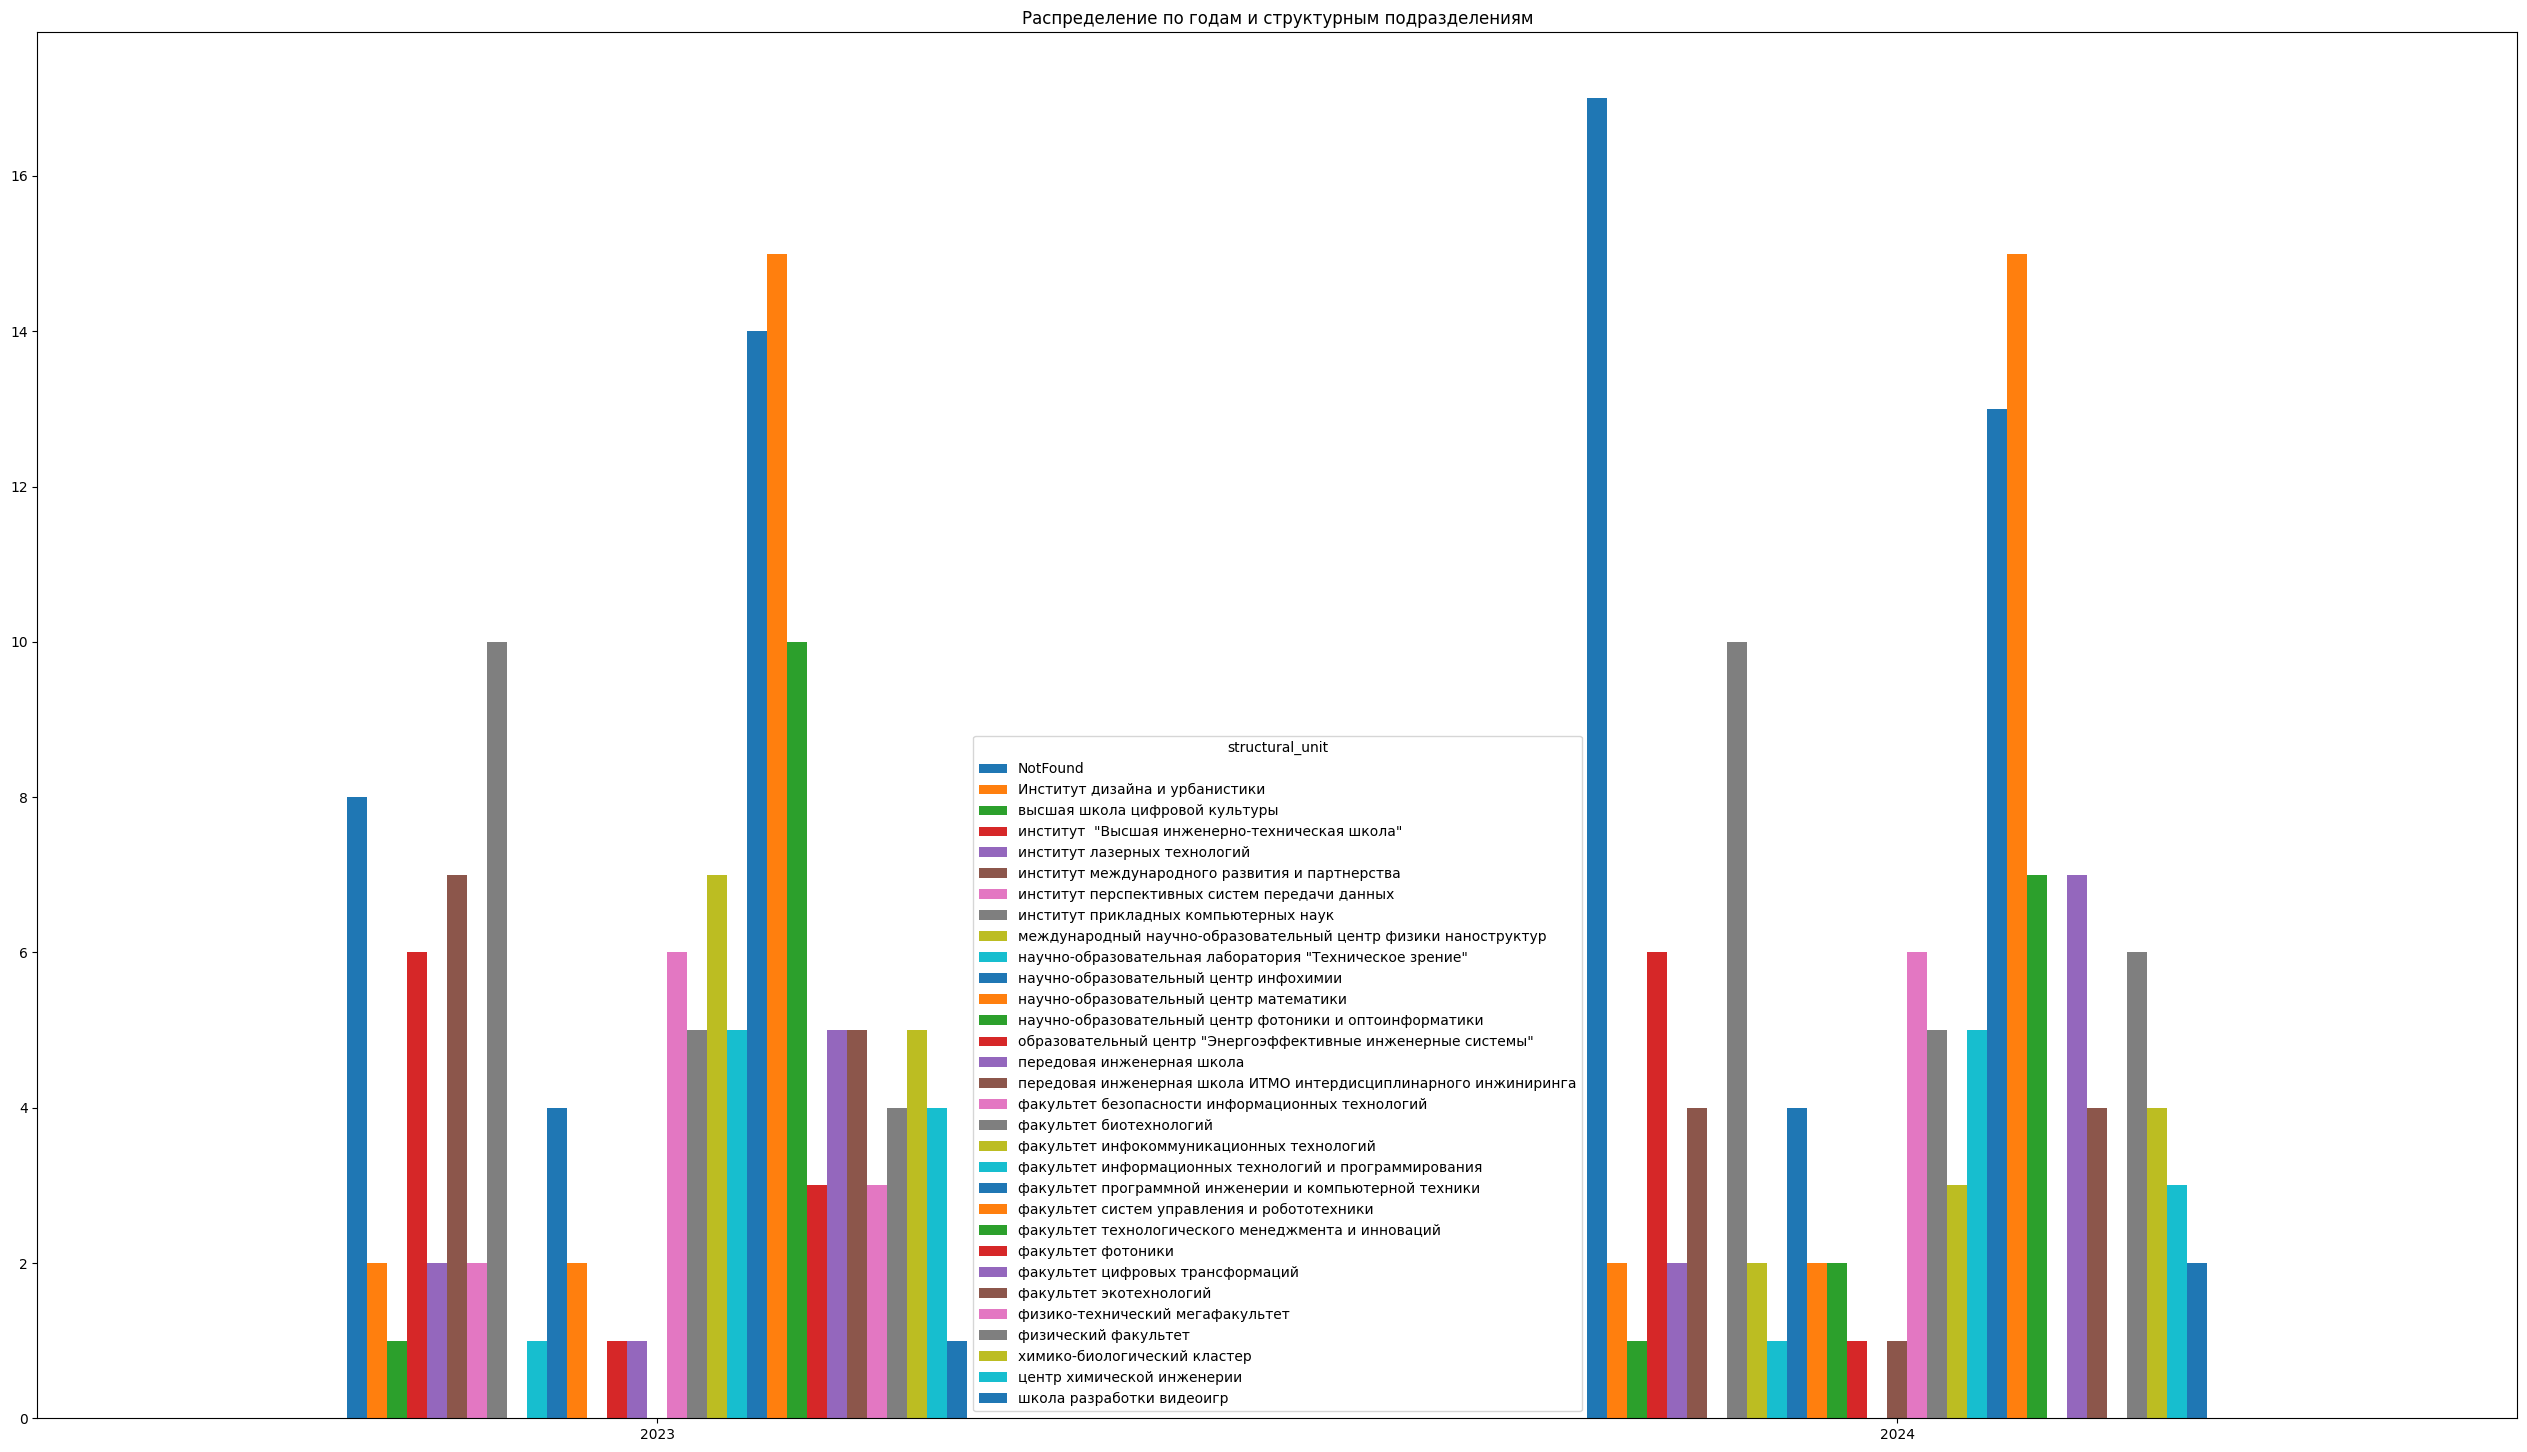

In [195]:
ct = crosstab(ddf['year'], ddf['structural_unit'])

ct.plot.bar(rot=0, title='Распределение по годам и структурным подразделениям', xlabel='', figsize=(32, 18))

<Axes: title={'center': 'Распределение по годам и редакторам'}>

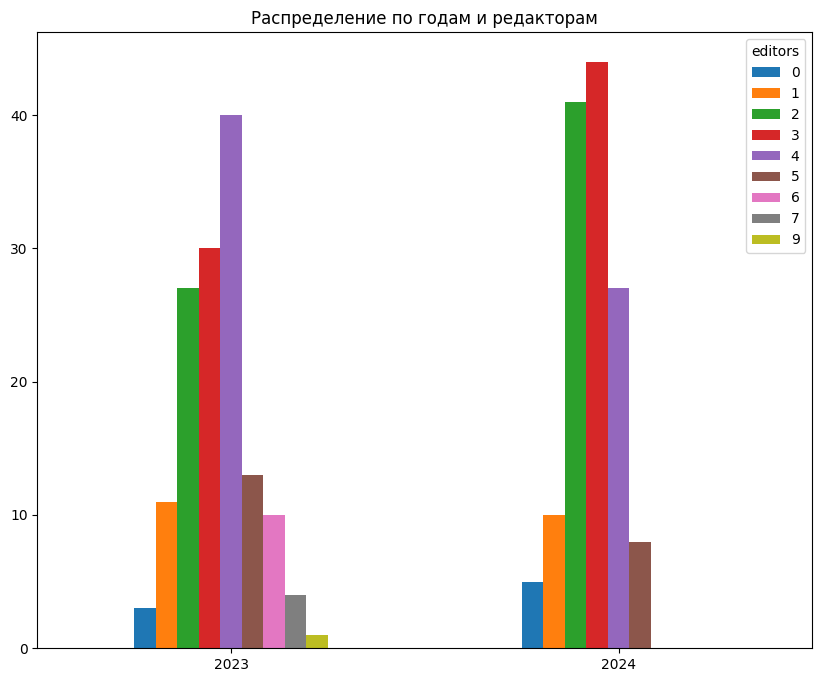

In [184]:
ct = crosstab(ddf['year'], ddf['editors'].apply(lambda x: len(x)))

ct.plot.bar(rot=0, title='Распределение по годам и редакторам', xlabel='', figsize=(10, 8))

Напишите выводы по графикам

Количество академических планов квалификации "магистр" намного больше чем квалификацй "бакалавр"

При этом количество планов по годам распределено поровну

Так же нашлось много планов с неопределенным структурным подразделениям

Почти у всех программ есть хотя один редактор

## Задание 1.4 Анализ


Найдите планы со статусом проверенные ('verified') , у которых некорректная трудоемкость (laboriousness). Корректная трудоемкость для бакалавриата - 240, для магистратуры - 120.

Для таких планов выведите год набора, id плана, ИСУ ИД плана (это уже третий id плана, и он всегда состоит из 5 цифр), название структурного подразделения (structural unit -> title) и список редакторов (editors)

In [23]:
from pandas import concat

inc1 = ddf[ddf['on_check'] == 'verified'][ddf['qualification'] == 'master'][ddf['laboriousness'] != 120]
inc2 = ddf[ddf['on_check'] == 'verified'][ddf['qualification'] == 'bachelor'][ddf['laboriousness'] != 240]

incDf = concat([inc1, inc2], ignore_index=True)

incDf['editors'] = incDf['editors'].apply(lambda x: [f"{y['isu_number']} {y['last_name']} {y['first_name']}" for y in x])

incDf[['year', 'ap_isu_id', 'structural_unit', 'editors']]

<ipython-input-23-2546b6669589>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inc1 = ddf[ddf['on_check'] == 'verified'][ddf['qualification'] == 'master'][ddf['laboriousness'] != 120]
<ipython-input-23-2546b6669589>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inc2 = ddf[ddf['on_check'] == 'verified'][ddf['qualification'] == 'bachelor'][ddf['laboriousness'] != 240]


,year,ap_isu_id,structural_unit,editors
0,2023,0,NotFound,[]
1,2023,18397,институт международного развития и партнерства,"[364389 Росс Мария, 362849 Букарева Татьяна, 2..."
2,2023,18405,факультет биотехнологий,"[275087 Наумова Алла, 167168 Соснина Ольга, 15..."
3,2023,18416,факультет экотехнологий,"[165829 Плужникова Дарья, 241191 Маненкова Анн..."
4,2023,18414,факультет экотехнологий,"[165829 Плужникова Дарья, 241191 Маненкова Анна]"
5,2023,18361,научно-образовательный центр инфохимии,"[337555 Зырянова Полина, 246194 Стекольщикова ..."
6,2023,18366,институт международного развития и партнерства,"[103466 Горлушкина Наталия, 360149 Думачева Ве..."
7,2023,18340,факультет экотехнологий,"[241191 Маненкова Анна, 165829 Плужникова Дарь..."
8,2023,28097,факультет инфокоммуникационных технологий,"[134011 Зленко Андрей, 165587 Приз Мария, 3068..."
9,2023,18362,факультет биотехнологий,"[275087 Наумова Алла, 167168 Соснина Ольга, 15..."
